<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/component-1/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os, shutil, hashlib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
INIT_LR = 1e-3
WD = 1e-5
EPOCHS = 30
THRESHOLD = 0.3 

data_dir = Path("D:/Data1_Split")
duplicate_dir = Path("D:/Duplicates")
os.makedirs(duplicate_dir, exist_ok=True)

In [16]:
def hash_img(path): return hashlib.md5(open(path, 'rb').read()).hexdigest()
def remove_duplicates(data_dir, duplicate_dir):
    seen = {}
    for category in ['Fundus', 'Non Fundus']:
        folder = data_dir / category
        for image in folder.iterdir():
            if image.is_file():
                h = hash_img(image)
                if h in seen:
                    shutil.move(str(image), duplicate_dir / image.name)
                else:
                    seen[h] = image
remove_duplicates(data_dir, duplicate_dir)

In [17]:
def collect_data(data_dir):
    X, y = [], []
    for label, category in enumerate(['Fundus', 'Non Fundus']):
        for img in (data_dir / category).glob("*"):
            if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tif']:
                X.append(str(img))
                y.append(label)
    return X, y

X, y = collect_data(data_dir)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=SEED)

def make_df(X, y):
    return pd.DataFrame({'filename': X, 'class': ['Fundus' if i == 0 else 'Non Fundus' for i in y]})

train_df, val_df, test_df = make_df(X_train, y_train), make_df(X_val, y_val), make_df(X_test, y_test)

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.6, 1.4],
    zoom_range=0.3,
    rotation_range=30,
    shear_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.25,
    height_shift_range=0.25,
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary',
    batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary',
    batch_size=BATCH_SIZE, shuffle=False)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary',
    batch_size=BATCH_SIZE, shuffle=False)

class_counts = Counter(y_train)
total = sum(class_counts.values())
class_weight = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}

Found 4791 validated image filenames belonging to 2 classes.
Found 1198 validated image filenames belonging to 2 classes.
Found 1057 validated image filenames belonging to 2 classes.


In [19]:
def build_model():
    base_model = EfficientNetV2B0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(WD))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

model = build_model()

lr_schedule = CosineDecay(initial_learning_rate=INIT_LR, decay_steps=EPOCHS * len(train_gen))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

early_stop = EarlyStopping(patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_nonfundus_fixed.keras", save_best_only=True)

In [20]:
history = model.fit(
    train_gen, validation_data=val_gen, epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight, verbose=1
)

for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.fit(train_gen, validation_data=val_gen, epochs=4,
          callbacks=[early_stop], class_weight=class_weight, verbose=1)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.5876 - loss: 0.8118 - precision_4: 0.5716 - recall_4: 0.5956 - val_accuracy: 0.4825 - val_loss: 0.6996 - val_precision_4: 0.4825 - val_recall_4: 1.0000
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2151s 14s/step - accuracy: 0.6678 - loss: 0.6706 - precision_4: 0.6477 - recall_4: 0.6622 - val_accuracy: 0.4825 - val_loss: 0.6431 - val_precision_4: 0.4825 - val_recall_4: 1.0000
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 2511s 17s/step - accuracy: 0.6991 - loss: 0.6405 - precision_4: 0.6795 - recall_4: 0.6937 - val_accuracy: 0.8222 - val_loss: 0.5561 - val_precision_4: 0.7603 - val_recall_4: 0.9221
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 729s 5s/step - accuracy: 0.6953 - loss: 0.6267 - precision_4: 0.6794 - recall_4: 0.6835 - val_accuracy: 0.8965 - val_loss: 0.4780 - val_precision_4: 0.9451 - val_recall_4: 0.8339
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.7250 - loss: 0.5877 - precision_4: 0.7183 - recall_4:


 Test Evaluation
Test Accuracy : 0.9839
Test Precision: 0.9843
Test Recall   : 0.9824
Test Loss     : 0.1624

 Train Evaluation
Train Accuracy : 0.9871
Train Precision: 0.9857
Train Recall   : 0.9875
Train Loss     : 0.1763

Classification Report:
              precision    recall  f1-score   support

      Fundus       0.99      0.96      0.98       547
  Non Fundus       0.96      0.99      0.98       510

    accuracy                           0.98      1057
   macro avg       0.98      0.98      0.98      1057
weighted avg       0.98      0.98      0.98      1057



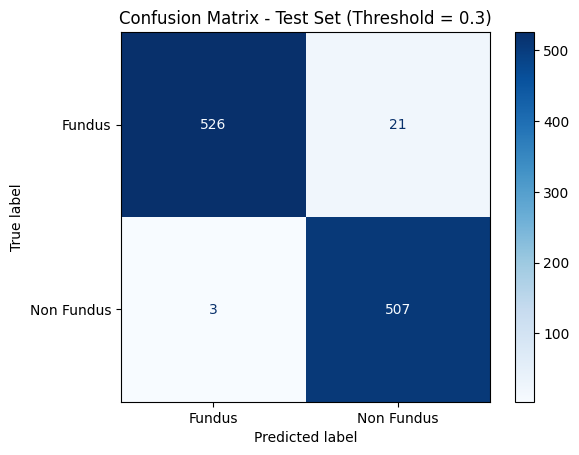

In [ ]:
print("\n Test Evaluation")
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall   : {test_rec:.4f}")
print(f"Test Loss     : {test_loss:.4f}")

print("\n Train Evaluation")
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_gen, verbose=0)
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Train Precision: {train_prec:.4f}")
print(f"Train Recall   : {train_rec:.4f}")
print(f"Train Loss     : {train_loss:.4f}")

y_true = test_gen.classes
y_pred_proba = model.predict(test_gen, verbose=0)
y_pred = (y_pred_proba > THRESHOLD).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fundus', 'Non Fundus']))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Fundus', 'Non Fundus']).plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set (Threshold = 0.3)")
plt.grid(False)
plt.show()


In [22]:
model.save("final_fundus_nonfundus_classifier.h5")